## The following code is successfully executed in devcloud jupyterlab

<font size ="4">**Importing all the libraries**</font>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
import pickle
import time
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to /home/u194253/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194253/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [ ]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [ ]:
fake_data = pd.read_csv('data/Fake.csv')
#fake_data.head()

In [ ]:
true_data = pd.read_csv('data/True.csv')
#true_data.head()

Assigning Classes to the Dataset

In [ ]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [ ]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

## User defined function for data-visualization

In [ ]:
def visualize(dataFile,feature):
    plt.figure(figsize = (6,4))
    sns.set(style = "whitegrid",font_scale = 1.0)
    chart = sns.countplot(x = feature, data = data)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
    plt.show()
    #return sns.countplot(x=feature, data=dataFile, palette='hls')

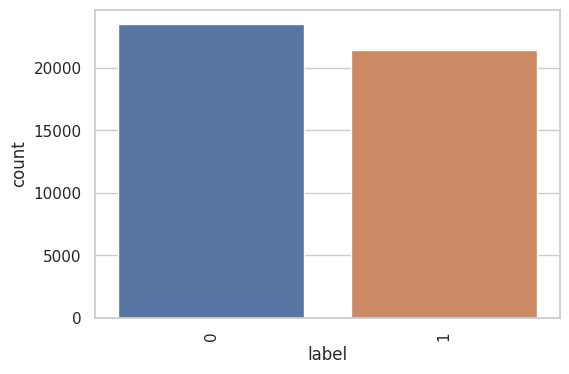

In [ ]:
visualize(data,'label')

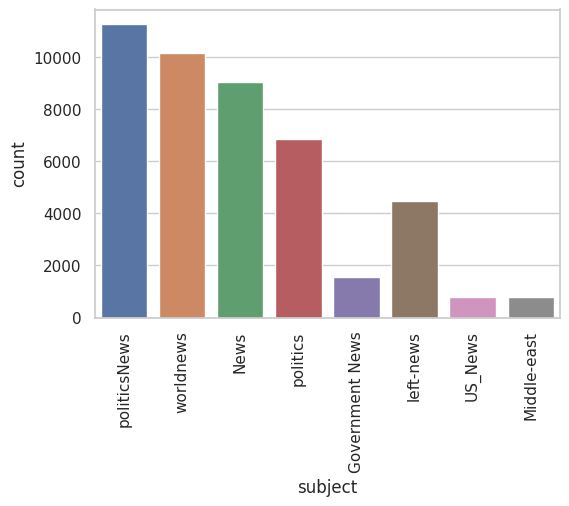

In [ ]:
visualize(data,'subject')

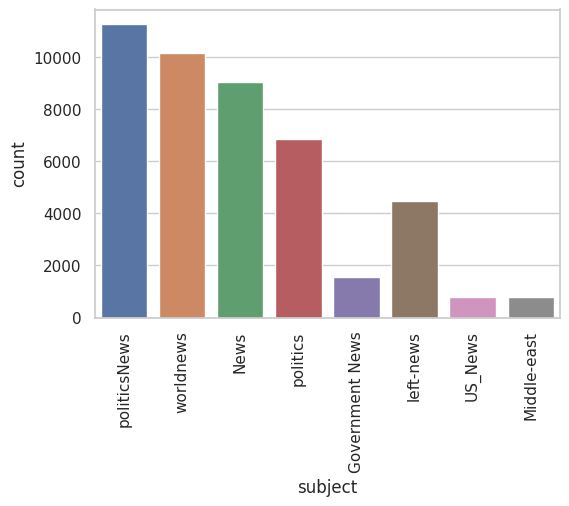

In [ ]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

<font size="4">**Data preprocessing**</font>

In [ ]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [ ]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [ ]:
data.shape

(44898, 2)

In [ ]:
def Check_forNAN(data):

    print("Wait...Checking for NANs in the Dataset is progressing...")
    print("Total NANs:",data.isnull().sum())
    print("Checking is completed successfully...\n")
    print(10*"--","\n")
    print("Summary of the dataframe:......\n")
    data.info()

    print("check finished.")

Check if there is any null value (If so, then we will drop those rows)

In [ ]:
Check_forNAN(data)

Wait...Checking for NANs in the Dataset is progressing...
Total NANs: text     0
label    0
dtype: int64
Checking is completed successfully...

-------------------- 

Summary of the dataframe:......

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB
check finished.


 Now we have to shuffle the dataset to prevent the model to get bias

In [ ]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,"WOW! SEAN SPICER Destroys BBC, New York Times ...",0
1,North Carolina transgender bathroom law faces ...,1
2,Iowa governor urges caucus-goers to say 'No' t...,1
3,Numbskull Ben Carson Just Managed To P*ss Off...,0
4,“They Will Kill Him Before They Let Him Become...,0


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

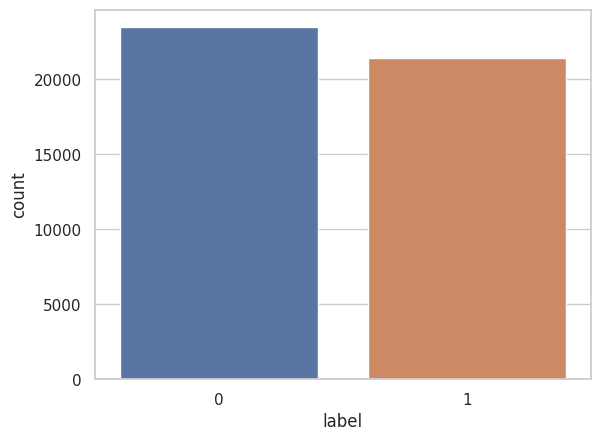

In [ ]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

## Stemming

In [ ]:
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

In [ ]:
from nltk.corpus import stopwords

In [ ]:
def remove_stopwords(tokenized_column):
    stops = set(stopwords.words("english"))
    return [word for word in tokenized_column if not word in stops]

In [ ]:
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokenized_column]

In [ ]:
def rejoin_words(tokenized_column):
    return ( " ".join(tokenized_column))

In [ ]:
## Creating Data cleaning and pre-processing function
def PreProcess(data):
    data['tokenized'] = data.apply(lambda x: tokenize(x['text']), axis=1)
    data['stopwords_removed'] = data.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)
    data['stemmed'] = data.apply(lambda x: apply_stemming(x['stopwords_removed']), axis=1)
    data['rejoined'] = data.apply(lambda x: rejoin_words(x['stemmed']), axis=1)

In [ ]:
# calling the preprocesss function
time_start = time.time()
PreProcess(data)
print('Preprocessing done! Time elapsed: {} seconds'.format(time.time()-time_start))

Preprocessing done! Time elapsed: 270.8038194179535 seconds


In [ ]:
from IPython.display import HTML
HTML(f"Spliting the dataframe into data and label")

In [ ]:
## Spliting the dataframe into data and label

data.label = data.label.astype(str)
#data.label = data.label.str.strip()
dict = { 'REAL' : 1 , 'FAKE' : '0'}
#data['label'] = data['label'].map(dict)
data['label'].head()

X = data['rejoined']
y = data['label']

## Visualization of bag of words and word count

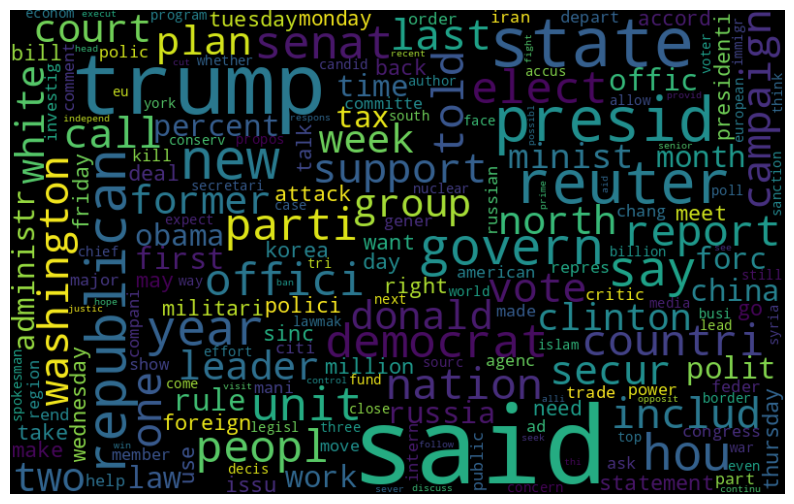

In [ ]:
from wordcloud import WordCloud
fake_data = data[data["label"] == "1"]
all_words = ' '.join([text for text in fake_data.rejoined])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

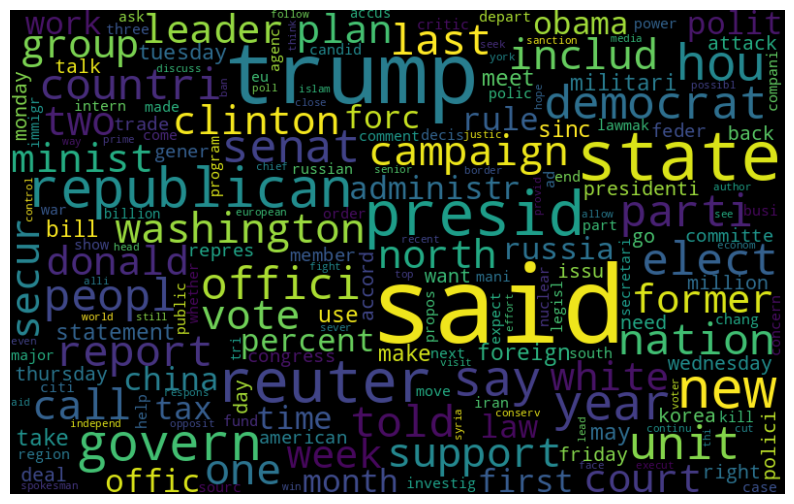

In [ ]:
from wordcloud import WordCloud
true_data = data[data["label"] == "1"]
all_words = ' '.join([text for text in true_data.rejoined])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

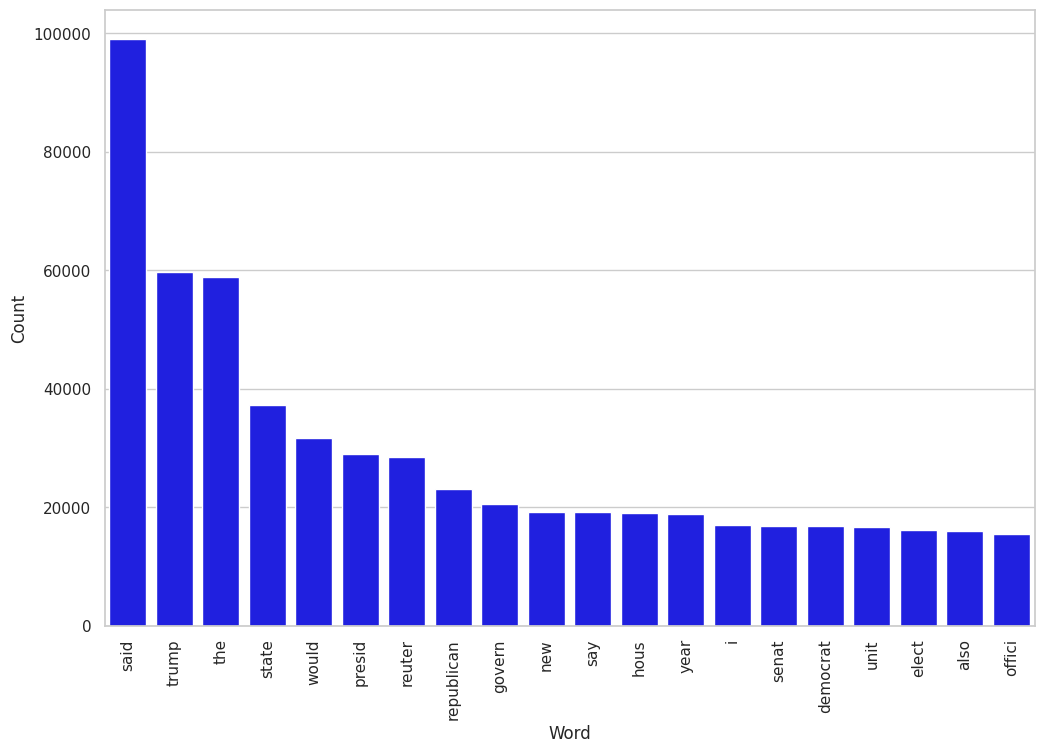

In [ ]:
# plotting word cound after pre-processing
counter(data[data['label'] == '1'], 'rejoined', 20)

## Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = CountVectorizer()


In [ ]:
time_start = time.time()
#count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.fit_transform(X)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)
print('TF-IDF matrix creation done! Time elapsed: {} seconds'.format(time.time()-time_start))
print(tf_idf_matrix)

TF-IDF matrix creation done! Time elapsed: 6.082367420196533 seconds
  (0, 74901)	0.1323392164390422
  (0, 74871)	0.17267355661390102
  (0, 74051)	0.056214427958917526
  (0, 73257)	0.040303086128114
  (0, 73166)	0.053785867826048155
  (0, 73093)	0.05818702867345725
  (0, 72825)	0.029768582731020513
  (0, 72448)	0.03262067099990275
  (0, 71465)	0.026513290220384164
  (0, 70687)	0.02562750498412685
  (0, 69403)	0.04958974024346375
  (0, 68954)	0.07528210464653502
  (0, 68384)	0.018747814158989084
  (0, 68358)	0.08722366605964285
  (0, 68121)	0.08513349874656143
  (0, 67806)	0.050789877557813466
  (0, 67329)	0.03636365185933037
  (0, 67019)	0.11127564617366201
  (0, 66639)	0.09072548995093438
  (0, 66286)	0.08947391562327768
  (0, 63697)	0.057039499735297275
  (0, 63694)	0.03608484983134154
  (0, 63010)	0.04639783247783994
  (0, 62642)	0.28725994740816074
  (0, 62616)	0.04525942186269085
  :	:
  (44897, 2341)	0.03970667962690189
  (44897, 2250)	0.02417135372159503
  (44897, 2035)	0.026758

In [ ]:
tf_idf_matrix.shape

(44898, 75749)

In [ ]:
pickle.dump(tfidf,open('./tfidf_vectorizer.pkl', 'wb'))

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# N features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k = 1000)
X_small = chi2_features.fit_transform(tf_idf_matrix, y)

## Splitting data for training and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix,y, random_state=21)

In [ ]:
print(x_test[:20,:])

  (0, 74901)	0.028251241213793382
  (0, 74643)	0.03687255888883613
  (0, 74037)	0.0158618690429979
  (0, 73398)	0.03498438516571858
  (0, 73053)	0.04417496913135011
  (0, 72696)	0.022313243185519364
  (0, 72686)	0.02667458132046943
  (0, 72664)	0.03832635433677206
  (0, 72605)	0.02096677467366378
  (0, 72538)	0.02352868200515388
  (0, 72448)	0.055709832339745836
  (0, 71822)	0.0775815248228952
  (0, 71465)	0.0452796005623866
  (0, 70687)	0.021883424868175825
  (0, 70415)	0.05673322321039905
  (0, 69754)	0.05430894633663857
  (0, 69137)	0.021243538138257627
  (0, 68923)	0.039598936051845536
  (0, 68724)	0.026345501442017444
  (0, 68391)	0.3129970468452051
  (0, 68384)	0.22412362654219348
  (0, 68121)	0.024231940444966314
  (0, 67019)	0.07601496108832428
  (0, 66644)	0.07204745026257854
  (0, 66602)	0.044364634841406674
  :	:
  (19, 6741)	0.026198779644242654
  (19, 5915)	0.023004532666043697
  (19, 4776)	0.02932104190944889
  (19, 4765)	0.050924640249122466
  (19, 4461)	0.03971002277530

In [ ]:
x_train.shape

(33673, 75749)

<font size="4">**Model training, Evaluation, and Prediction**</font>

## Fake-news detection using ML

### 1. Logistic Regression

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_train

31372    0
33971    1
21984    1
10861    0
16801    0
        ..
16432    0
8964     0
5944     0
5327     1
15305    1
Name: label, Length: 33673, dtype: object

In [ ]:
from timeit import default_timer as timer
from sklearn import metrics
from sklearn.model_selection import train_test_split
import warnings
from IPython.display import HTML
warnings.filterwarnings('ignore')

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
from sklearn.linear_model import LogisticRegression
params = {
    'C': 0.1,
    'solver': 'lbfgs',
    'multi_class': 'multinomial',
    'n_jobs': -1,
}
start = timer()
classifier = LogisticRegression(**params).fit(x_train, y_train)
train_unpatched = timer() - start
f"Original Scikit-learn time: {train_unpatched:.2f} s"

'Original Scikit-learn time: 3.89 s'

In [ ]:
y_predict = classifier.predict_proba(x_test)
log_loss_opt = metrics.log_loss(y_test, y_predict)
f"Intel® extension for Scikit-learn Log Loss: {log_loss_opt} s"

'Intel® extension for Scikit-learn Log Loss: 0.15628841961145287 s'

In [ ]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [ ]:
#logit model
from sklearn.linear_model import LogisticRegression
time_start = time.time()
logitmodel = LogisticRegression()
logitmodel.fit(x_train, y_train)
y_pred=logitmodel.predict(x_test)
Accuracy = logitmodel.score(x_test, y_test)
print(Accuracy*100)
print('Logit Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

98.80623608017818
Logit Model done! Time elapsed: 7.290025234222412 seconds


In [ ]:
train_unpatched = timer() - start
f"Original Scikit-learn time: {train_unpatched:.2f} s"

'Original Scikit-learn time: 13.26 s'

In [ ]:
y_predict = logitmodel.predict_proba(x_test)
log_loss_original = metrics.log_loss(y_test, y_predict)
f"Original Scikit-learn Log Loss: {log_loss_original} s"

'Original Scikit-learn Log Loss: 0.07855761988247656 s'

In [ ]:
HTML(f"<h3>Compare Log Loss metric of patched Scikit-learn and original</h3>"
     f"Log Loss metric of patched Scikit-learn: {log_loss_opt} <br>"
     f"Log Loss metric of unpatched Scikit-learn: {log_loss_original} <br>"
     f"Metrics ratio: {log_loss_opt/log_loss_original} <br>"
     )

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
y_pred=logitmodel.predict(x_train)
mse = mean_squared_error(y_train, y_pred)
rmse = sqrt(mse)
print("RMSE of Logit model-training:",rmse)

RMSE of Logit model-training: 0.08599214226581622


In [ ]:
y_pred=logitmodel.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of Logit model-testing:",rmse)

RMSE of Logit model-testing: 0.10925950392628672


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5845
           1       0.99      0.99      0.99      5380

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5779   66]
 [  68 5312]]


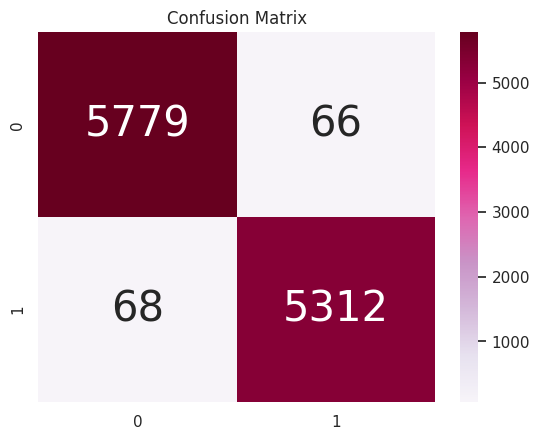

In [ ]:
# confusion matrix sns heatmap
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="PuRd", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

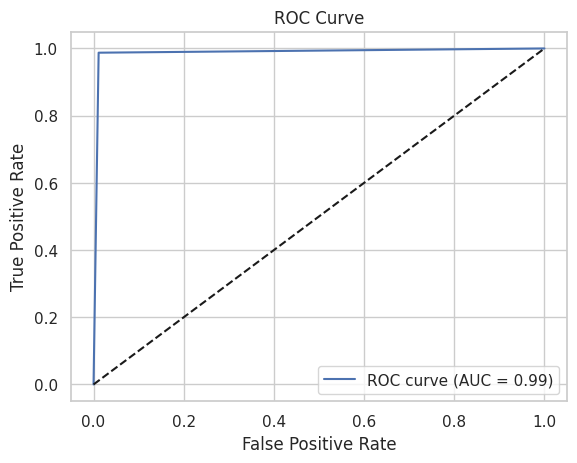

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single mode
y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

### 2. Navie Bayes classification model

In [ ]:
#NB
from sklearn.naive_bayes import MultinomialNB
time_start = time.time()
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred=NB.predict(x_test)
Accuracy = NB.score(x_test, y_test)
print(Accuracy*100)
print('NB Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

93.80846325167039
NB Model done! Time elapsed: 0.17455101013183594 seconds


In [ ]:
import numpy as np

In [ ]:
y_pred

array(['0', '1', '1', ..., '0', '1', '0'], dtype='<U1')

In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5845
           1       0.95      0.92      0.93      5380

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



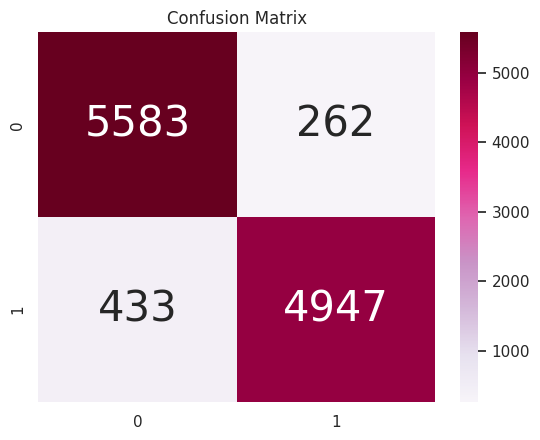

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="PuRd", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
y_pred =y_pred.astype(np.float)

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of NB model-testing:",rmse)

RMSE of NB model-testing: 0.2488279877411225


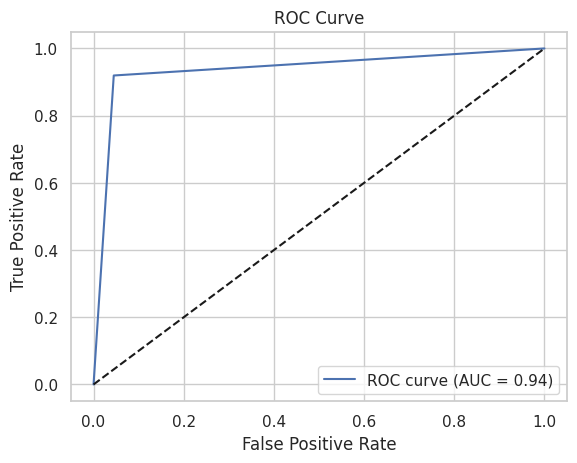

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

### 3. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
time_start = time.time()
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
Accuracy = clf.score(x_test, y_test)
print(Accuracy*100)
print('DT Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

99.58129175946547
DT Model done! Time elapsed: 29.24653673171997 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5845
           1       1.00      0.99      1.00      5380

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
y_pred=clf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of DT model-testing:",rmse)

RMSE of DT model-testing: 0.06470766882947655


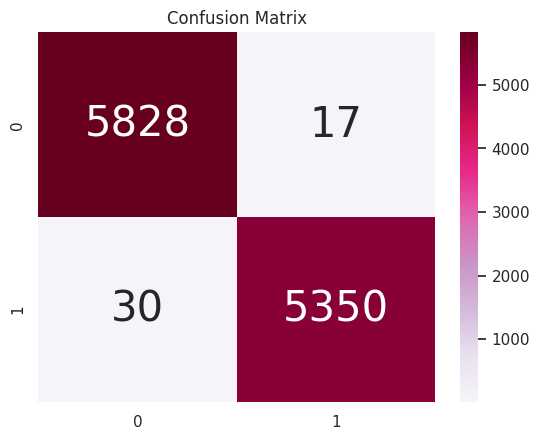

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="PuRd", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

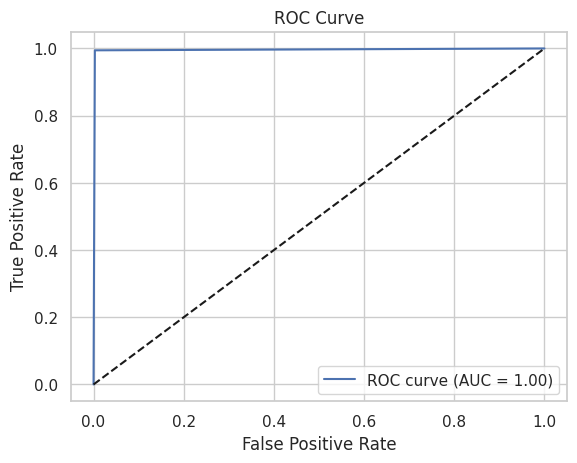

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

### 4. Passive-Aggressive Classifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
time_start = time.time()
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(x_train,y_train)
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print('PAC Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

Accuracy: 99.47%
PAC Model done! Time elapsed: 0.28920698165893555 seconds


In [ ]:
#Predict on the test set and calculate accuracy
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 99.47%


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5845
           1       1.00      0.99      0.99      5380

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



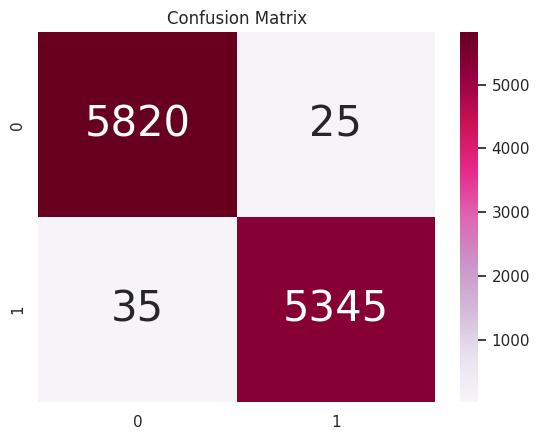

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="PuRd", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
y_pred=y_pred.astype(np.float)

#y_pred=pac.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("PAC model-testing:",rmse)

PAC model-testing: 0.07311095390768581


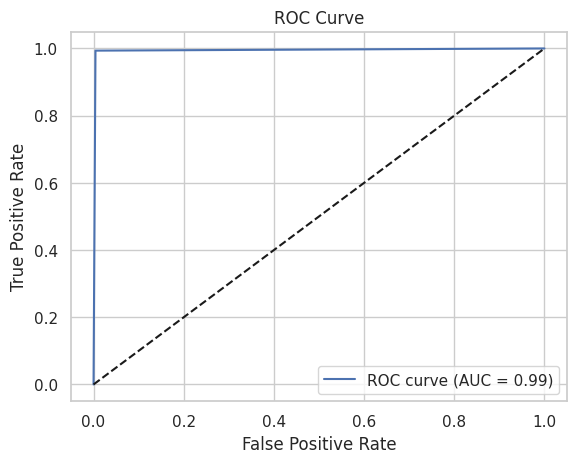

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

### 5. Random Forest Regressor


In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': 150,
    'random_state': 44,
    'n_jobs': -1
}
start = timer()
rf = RandomForestRegressor(**params).fit(x_train, y_train)
train_patched = timer() - start
f"Intel® extension for Scikit-learn time: {train_patched:.2f} s"

'Intel® extension for Scikit-learn time: 217.44 s'

In [ ]:
y_pred = rf.predict(x_test)
mse_opt = metrics.mean_squared_error(y_test, y_pred)
f'Intel® extension for Scikit-learn Mean Squared Error: {mse_opt}'

'Intel® extension for Scikit-learn Mean Squared Error: 0.003083169512496907'

In [ ]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
start = timer()
rf = RandomForestRegressor(**params).fit(x_train, y_train)
train_unpatched = timer() - start
f"Original Scikit-learn time: {train_unpatched:.2f} s"

'Original Scikit-learn time: 217.49 s'

In [ ]:
y_pred = rf.predict(x_test)
mse_original = metrics.mean_squared_error(y_test, y_pred)
f'Original Scikit-learn Mean Squared Error: {mse_opt}'

'Original Scikit-learn Mean Squared Error: 0.003083169512496907'

In [ ]:
HTML(f"<h3>Compare Log Loss metric of patched Scikit-learn and original</h3>"
     f"Log Loss metric of patched Scikit-learn: {log_loss_opt} <br>"
     f"Log Loss metric of unpatched Scikit-learn: {log_loss_original} <br>"
     f"Metrics ratio: {log_loss_opt/log_loss_original} <br>"
     )

In [ ]:
from sklearn.metrics import accuracy_score
time_start = time.time()
rfr=RandomForestRegressor()
rfr.fit(x_train,y_train)
y_pred=rfr.predict(x_test)


In [ ]:
print(y_pred)
y_pred = y_pred.astype('<U1')

['0' '1' '1' ... '0' '1' '0']


In [ ]:
Accuracy = rfr.score(x_test, y_test)
print(Accuracy*100)
print('RFR Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

98.75690820165299
RFR Model done! Time elapsed: 1849.2623617649078 seconds


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5845
           1       1.00      0.91      0.95      5380

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



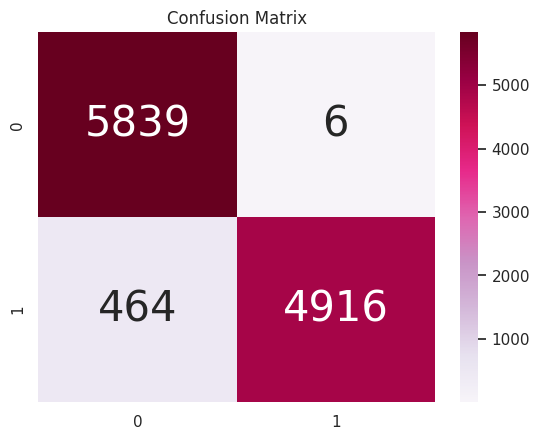

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="PuRd", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
y_pred=y_pred.astype(np.float)

#y_pred=pac.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("PAC model-testing:",rmse)

PAC model-testing: 0.20462361558102748


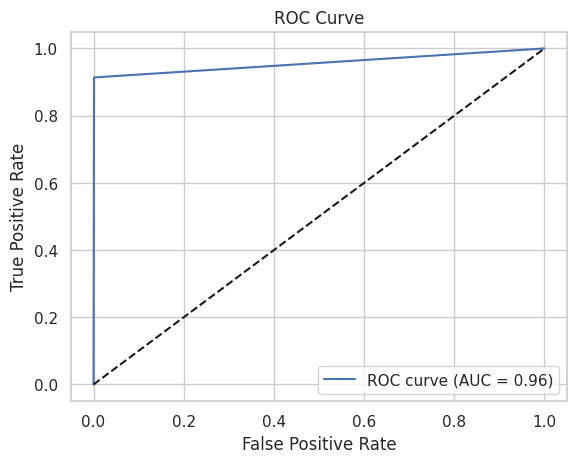

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'y_true' contains the true labels and 'y_scores' contains the predicted probabilities or decision scores for the positive class of a single model


y_true=y_test.to_numpy()
y_true = y_true.astype(str)
y_pred1 = y_pred.astype(float)

fpr, tpr, thresholds = roc_curve(y_true, y_pred1,pos_label='1')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') # Plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [ ]:
pickle.dump(clf,open('./selected_model.pkl', 'wb'))

In [ ]:
pickle.dump(clf,open('./selected_model.pkl', 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open('./selected_model.pkl', 'rb'))

<font size="4">**Using the saved model for fake-news prediction from a new data**</font>

In [ ]:
text=["Chat GPT is Blocked in India"]
data1=pd.DataFrame(text,columns=["text"])

In [ ]:
data1.head()

,text
0,Chat GPT is Blocked in India


In [ ]:
PreProcess(data1)

In [ ]:
import numpy as np


def fake_news_detector(data1):
    #PreProcess(data1)
    review = data1['rejoined']
    count_vectorizer.fit_transform(review)
    freq_term_matrix1 = count_vectorizer.transform(review)
    tfidf1 = TfidfTransformer(norm = "l2")
    tfidf1.fit(freq_term_matrix)
    tf_idf_matrix1 = tfidf.fit_transform(freq_term_matrix)
    prediction=loaded_model.predict(tf_idf_matrix1)
    if prediction[0] == '0':
        print("Prediction of the News : Looking Fake News ")
    else:
        print("Prediction of the News : Looking Real News ")

In [ ]:
fake_news_detector(data1)

Prediction of the News : Looking Fake News 


## Running a small model with feature extraction

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_small,y, random_state=21)

In [ ]:
x_train.shape

(33673, 1000)

In [ ]:
x_test.shape

(11225, 1000)

In [ ]:
#logit short model
#from sklearn.linear_model import LogisticRegression
time_start = time.time()
logitmodel = LogisticRegression()
logitmodel.fit(x_train, y_train)
y_pred=logitmodel.predict(x_test)
Accuracy = logitmodel.score(x_test, y_test)
print(Accuracy*100)
print('Logit Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

98.43207126948775
Logit Model done! Time elapsed: 1.081812858581543 seconds


In [ ]:
y_pred=logitmodel.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of Logit small model-testing:",rmse)

RMSE of Logit small model-testing: 0.1252169609323054


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5845
           1       0.98      0.98      0.98      5380

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225



In [ ]:
#NB
from sklearn.naive_bayes import MultinomialNB
time_start = time.time()
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred=NB.predict(x_test)
Accuracy = NB.score(x_test, y_test)
print(Accuracy*100)
print('NB Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

93.9599109131403
NB Model done! Time elapsed: 0.31019091606140137 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5845
           1       0.95      0.92      0.94      5380

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



In [ ]:
y_pred =y_pred.astype(np.float)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of NB model-testing:",rmse)

RMSE of NB model-testing: 0.2457659269886631


In [ ]:
from sklearn.tree import DecisionTreeClassifier
time_start = time.time()
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
Accuracy = clf.score(x_test, y_test)
print(Accuracy*100)
print('DT Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

99.57238307349667
DT Model done! Time elapsed: 5.4174041748046875 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5845
           1       1.00      1.00      1.00      5380

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of DT model-testing:",rmse)

RMSE of DT model-testing: 0.06539242513497574


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
time_start = time.time()
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(x_train,y_train)
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')
print('PAC Model done! Time elapsed: {} seconds'.format(time.time()-time_start))

Accuracy: 99.45%
PAC Model done! Time elapsed: 0.15990686416625977 seconds


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5845
           1       0.99      0.99      0.99      5380

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
y_pred =y_pred.astype(np.float)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("RMSE of PAC model-testing:",rmse)

RMSE of PAC model-testing: 0.07431948129977867
